In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision.models as models
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the labeled dataset
dataset = ImageFolder(root='C:/Users/sevmou2300/Desktop/Home/Postdoc/Task1_Plant_categorisation/Plantvation+Holmen-Spring23/Top camera/ResizedImages', transform=transform)

# Split the dataset into training and test sets
train_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the pre-trained MobileNetV2 model and modify it as a feature extractor
num_classes = len(dataset.classes)
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers in the MobileNetV2 model so they are not updated during training
for param in mobilenet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one that has the correct number of output classes
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)
model = mobilenet.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

# Create some empty arrays to store logs 
loss_log = []
accuracy_log = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += torch.sum(predictions == labels).item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100.0 * train_correct / len(train_loader.dataset)

    # Print training progress
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.2f}%")
    
    # Store training stats after each epoch
    loss_log.append(train_loss)
    accuracy_log.append(train_accuracy)

# Testing phase
model.eval()
test_loss = 0.0
test_correct = 0

test_probabilities = []  # Store predicted probabilities instead of class labels
test_labels_list = []

test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        
        probabilities = torch.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_correct += torch.sum(predictions == labels).item()

        test_probabilities.extend(probabilities.cpu().tolist())  # Store probabilities
        test_labels_list.extend(labels.cpu().tolist())
        test_predictions.extend(predictions.cpu().tolist())  # Store predictions

test_loss /= len(test_loader.dataset)
test_accuracy = 100.0 * test_correct / len(test_loader.dataset)

# Convert the test_probabilities and test_labels_list to numpy arrays
test_probabilities = np.array(test_probabilities)
test_labels_array = np.array(test_labels_list)

# Calculate testing metrics
test_precision_weighted = precision_score(test_labels_array, test_predictions, average='weighted')
test_recall_weighted = recall_score(test_labels_array, test_predictions, average='weighted')
test_f1_weighted = f1_score(test_labels_array, test_predictions, average='weighted')
test_auc_weighted = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='weighted')

test_precision_macro = precision_score(test_labels_array, test_predictions, average='macro')
test_recall_macro = recall_score(test_labels_array, test_predictions, average='macro')
test_f1_macro = f1_score(test_labels_array, test_predictions, average='macro')
test_auc_macro = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='macro')

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Weighted Precision: {test_precision_weighted:.4f} - Test Weighted Recall: {test_recall_weighted:.4f} - Test Weighted F1 Score: {test_f1_weighted:.4f} - Test Weighted AUC: {test_auc_weighted:.4f}")
print(f"Test Macro Precision: {test_precision_macro:.4f} - Test Macro Recall: {test_recall_macro:.4f} - Test Macro F1 Score: {test_f1_macro:.4f} - Test Macro AUC: {test_auc_macro:.4f}")

# Save the trained model
torch.save(model.state_dict(), "TL_MobileNetV2_Top.pth")


# Save the results to an Excel file
results_dict = {
    'Test Loss': [test_loss],
    'Test Accuracy': [test_accuracy],
    'Test Weighted Precision': [test_precision_weighted],
    'Test Weighted Recall': [test_recall_weighted],
    'Test Weighted F1 Score': [test_f1_weighted],
    'Test Weighted AUC': [test_auc_weighted],
    'Test Macro Precision': [test_precision_macro],
    'Test Macro Recall': [test_recall_macro],
    'Test Macro F1 Score': [test_f1_macro],
    'Test Macro AUC': [test_auc_macro],
}

results_df = pd.DataFrame(results_dict)
results_df.to_excel("TL_MobileNetV2_Top.xlsx", index=False)






C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Loss: 0.0220 - Accuracy: 69.68%
Epoch 2/10 - Loss: 0.0166 - Accuracy: 77.51%
Epoch 3/10 - Loss: 0.0149 - Accuracy: 79.24%
Epoch 4/10 - Loss: 0.0139 - Accuracy: 81.32%
Epoch 5/10 - Loss: 0.0160 - Accuracy: 79.73%
Epoch 6/10 - Loss: 0.0132 - Accuracy: 82.53%
Epoch 7/10 - Loss: 0.0133 - Accuracy: 82.61%
Epoch 8/10 - Loss: 0.0138 - Accuracy: 81.79%
Epoch 9/10 - Loss: 0.0130 - Accuracy: 82.11%
Epoch 10/10 - Loss: 0.0129 - Accuracy: 83.48%
Test Loss: 0.0109 - Test Accuracy: 85.10%
Test Weighted Precision: 0.8564 - Test Weighted Recall: 0.8510 - Test Weighted F1 Score: 0.8506 - Test Weighted AUC: 0.9739
Test Macro Precision: 0.8631 - Test Macro Recall: 0.8361 - Test Macro F1 Score: 0.8457 - Test Macro AUC: 0.9761


In [ ]:
# Testing phase
import numpy as np
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_probabilities = []  # Store predicted probabilities instead of class labels
test_labels_list = []

test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_correct += torch.sum(predictions == labels).item()
        test_total += labels.size(0)

        test_probabilities.extend(probabilities.cpu().tolist())  # Store probabilities
        test_labels_list.extend(labels.cpu().tolist())
        test_predictions.extend(predictions.cpu().tolist())  # Store predictions

test_loss /= len(test_loader.dataset)
test_accuracy = 100.0 * test_correct / test_total

# Convert the test_probabilities and test_labels_list to numpy arrays
test_probabilities = np.array(test_probabilities)
test_labels_array = np.array(test_labels_list)

# Calculate testing metrics
test_precision_weighted = precision_score(test_labels_array, test_predictions, average='weighted')
test_recall_weighted = recall_score(test_labels_array, test_predictions, average='weighted')
test_f1_weighted = f1_score(test_labels_array, test_predictions, average='weighted')
test_auc_weighted = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='weighted')

test_precision_macro = precision_score(test_labels_array, test_predictions, average='macro')
test_recall_macro = recall_score(test_labels_array, test_predictions, average='macro')
test_f1_macro = f1_score(test_labels_array, test_predictions, average='macro')
test_auc_macro = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='macro')

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Weighted Precision: {test_precision_weighted:.4f} - Test Weighted Recall: {test_recall_weighted:.4f} - Test Weighted F1 Score: {test_f1_weighted:.4f} - Test Weighted AUC: {test_auc_weighted:.4f}")
print(f"Test Macro Precision: {test_precision_macro:.4f} - Test Macro Recall: {test_recall_macro:.4f} - Test Macro F1 Score: {test_f1_macro:.4f} - Test Macro AUC: {test_auc_macro:.4f}")

# Save the trained model
torch.save(model.state_dict(), "trained_model_train_test_split.pth")

# Save the results to an Excel file
results_dict = {
    'Test Loss': [test_loss],
    'Test Accuracy': [test_accuracy],
    'Test Weighted Precision': [test_precision_weighted],
    'Test Weighted Recall': [test_recall_weighted],
    'Test Weighted F1 Score': [test_f1_weighted],
    'Test Weighted AUC': [test_auc_weighted],
    'Test Macro Precision': [test_precision_macro],
    'Test Macro Recall': [test_recall_macro],
    'Test Macro F1 Score': [test_f1_macro],
    'Test Macro AUC': [test_auc_macro],
}

results_df = pd.DataFrame(results_dict)
results_df.to_excel("TL_Resnet18_.xlsx", index=False)

Test Loss: 0.0118 - Test Accuracy: 84.75%
Test Weighted Precision: 0.8474 - Test Weighted Recall: 0.8475 - Test Weighted F1 Score: 0.8474 - Test Weighted AUC: 0.9689
Test Macro Precision: 0.8471 - Test Macro Recall: 0.8441 - Test Macro F1 Score: 0.8455 - Test Macro AUC: 0.9708


In [6]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize

**New Criteria**

In [3]:
from datetime import datetime
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision.models as models
from torch.utils.data import Dataset


# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_folder = ImageFolder(root=root, transform=transform)
        self.classes = self.image_folder.classes

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        filename = os.path.basename(self.image_folder.imgs[idx][0])
        
        return {'image': image, 'label': label, 'filename': filename}

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the labeled dataset using CustomDataset
dataset = CustomDataset(root='C:/Users/sevmou2300/Desktop/Home/Postdoc/Task1_Plant_categorisation/Plantvation+Holmen-Spring23/Top camera/ResizedImages', transform=transform)

# Split the dataset into training and test sets
train_size = int(0.2 * len(dataset))  # Adjust the split ratio as needed
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the pre-trained SqueezeNet model and modify it as a feature extractor
num_classes = len(dataset.classes)

mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers in the MobileNetV2 model so they are not updated during training
for param in mobilenet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one that has the correct number of output classes
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)
model = mobilenet.to(device)


# Load the state dictionary of the saved model
state_dict = torch.load("TL_MobileNetV2_Top.pth", map_location=torch.device(device))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [3]:
import pandas as pd
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Testing phase
import numpy as np
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_probabilities = []  # Store predicted probabilities instead of class labels
test_labels_list = []

test_predictions = []
test_filenames = []  # List to store filenames

# Load your Excel files and extract date information into a dictionary
# Replace 'path_to_excel_folder' with the actual path to your Excel files
excel_files = ['class_0.xlsx', 'class_1.xlsx', 'class_2.xlsx', 'class_3.xlsx']
date_info = {}


from datetime import datetime

# Function to calculate the time difference between two timestamps
def calculate_time_difference(time1, time2):
    datetime_format = "%Y:%m:%d %H:%M:%S"
    t1 = datetime.strptime(time1, datetime_format)
    t2 = datetime.strptime(time2, datetime_format)
    time_diff = abs((t1 - t2).total_seconds())  # Time difference in seconds
    return time_diff

# Assuming you have a function to load the creation date from the Excel file
def load_creation_date(image_title, excel_file):
    try:
        # Load the Excel file into a DataFrame
        df = pd.read_excel(excel_file)

        # Assuming the DataFrame has columns 'Image Title' and 'Creation Date'
        if 'Image Title' in df.columns and 'Creation Date' in df.columns:
            # Find the row where 'Image Title' matches the given image_title
            row = df[df['Image Title'] == image_title]

            # Check if a matching row was found
            if not row.empty:
                # Extract the creation date from the matching row
                creation_date = row.iloc[0]['Creation Date']

                # Ensure that the creation date is a string
                if isinstance(creation_date, str):
                    return creation_date

        # If the image title was not found or the date is not a string, return None
        return None
    except Exception as e:
        print(f"Error loading creation date for '{image_title}' from '{excel_file}': {str(e)}")
        return None

time_boundaries = [
    "2023:05:16 00:00:00",  # t0
    "2023:05:27 21:13:46",  # t1
    "2023:06:08 12:03:15",  # t2
    "2023:06:20 13:51:00",  # t3
    "2023:06:29 14:32:00"   # t4
]


model.eval()
test_loss = 0.0
test_correct = 0
test_correct_time_dependent = 0  # Counter for time-dependent correct predictions
test_total = 0
 # Initialize total penalty
total_penalty = 0
ATBD_Todal = 0
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch['image'], batch['label']
        filenames = batch['filename']

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_correct += torch.sum(predictions == labels).item()
        test_total += labels.size(0)

        test_probabilities.extend(probabilities.cpu().tolist())
        test_labels_list.extend(labels.cpu().tolist())
        test_predictions.extend(predictions.cpu().tolist())
        test_filenames.extend(filenames)
        
        # Constants
        THRESHOLD = 21600

       
        for i in range(len(filenames)):
            true_class = labels[i].item()
            predicted_class = predictions[i].item()
            image_title = filenames[i]
    
            # Check if true class equals predicted class
            if true_class == predicted_class:
                penalty = 1  # Set penalty to 0
                ATBD_Sample = 0  # Set ATBD_Sample to 0
            else:
                # Load creation date and calculate time differences
                creation_date = load_creation_date(image_title, excel_files[true_class])
                lower_bound = time_boundaries[predicted_class]
                upper_bound = time_boundaries[predicted_class + 1]
                time_diff_lower = calculate_time_difference(creation_date, lower_bound)
                time_diff_upper = calculate_time_difference(creation_date, upper_bound)
        
                # Calculate closeness
                time_difference = min(time_diff_lower, time_diff_upper)
        
                # Calculate penalty
                if time_difference <= THRESHOLD:
                    penalty = time_difference / THRESHOLD
                else:
                    penalty = 0
        
                # Calculate ATBD_Sample
                ATBD_Sample = max(0, time_difference - THRESHOLD)
    
            # Accumulate penalties
            total_penalty += penalty
            # Calculate ATBD_Todal (total penalty)
            ATBD_Todal += ATBD_Sample



# Calculate the time-dependent accuracy
time_dependent_accuracy = total_penalty / test_total
ATBD_Normalise=ATBD_Todal/test_total

# Calculate the regular accuracy
test_accuracy = test_correct / test_total

test_loss /= len(test_loader.dataset)


# Convert the test_probabilities and test_labels_list to numpy arrays
test_probabilities = np.array(test_probabilities)
test_labels_array = np.array(test_labels_list)

# Calculate testing metrics
test_precision_weighted = precision_score(test_labels_array, test_predictions, average='weighted')
test_recall_weighted = recall_score(test_labels_array, test_predictions, average='weighted')
test_f1_weighted = f1_score(test_labels_array, test_predictions, average='weighted')
test_auc_weighted = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='weighted')

test_precision_macro = precision_score(test_labels_array, test_predictions, average='macro')
test_recall_macro = recall_score(test_labels_array, test_predictions, average='macro')
test_f1_macro = f1_score(test_labels_array, test_predictions, average='macro')
test_auc_macro = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='macro')

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Weighted Precision: {test_precision_weighted:.4f} - Test Weighted Recall: {test_recall_weighted:.4f} - Test Weighted F1 Score: {test_f1_weighted:.4f} - Test Weighted AUC: {test_auc_weighted:.4f}")
print(f"Test Macro Precision: {test_precision_macro:.4f} - Test Macro Recall: {test_recall_macro:.4f} - Test Macro F1 Score: {test_f1_macro:.4f} - Test Macro AUC: {test_auc_macro:.4f}")


# Save the results to an Excel file
results_dict = {
    'Test Loss': [test_loss],
    'Test Accuracy': [test_accuracy],
    'Test Weighted Precision': [test_precision_weighted],
    'Test Weighted Recall': [test_recall_weighted],
    'Test Weighted F1 Score': [test_f1_weighted],
    'Test Weighted AUC': [test_auc_weighted],
    'Test Macro Precision': [test_precision_macro],
    'Test Macro Recall': [test_recall_macro],
    'Test Macro F1 Score': [test_f1_macro],
    'Test Macro AUC': [test_auc_macro],
    'Time Dependent Accuracy': [time_dependent_accuracy],
    'ATBD': [ATBD_Normalise],
}

results_df = pd.DataFrame(results_dict)
results_df.to_excel("MobileNet_Results.xlsx", index=False)

Test Loss: 0.0105 - Test Accuracy: 0.86%
Test Weighted Precision: 0.8641 - Test Weighted Recall: 0.8589 - Test Weighted F1 Score: 0.8583 - Test Weighted AUC: 0.9761
Test Macro Precision: 0.8706 - Test Macro Recall: 0.8430 - Test Macro F1 Score: 0.8528 - Test Macro AUC: 0.9782


In [7]:
ATBD_Normalise/3600

7.291909282459703

Test Loss: 0.0104 - Test Accuracy: 0.86%
Test Weighted Precision: 0.8656 - Test Weighted Recall: 0.8600 - Test Weighted F1 Score: 0.8597 - Test Weighted AUC: 0.9765
Test Macro Precision: 0.8727 - Test Macro Recall: 0.8451 - Test Macro F1 Score: 0.8549 - Test Macro AUC: 0.9784


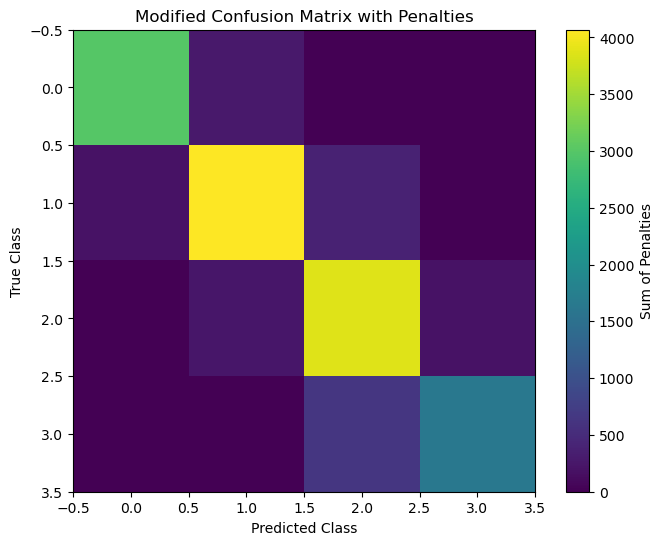

C:\Users\sevmou2300\AppData\Local\Temp\ipykernel_12056\855736389.py:241: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


ValueError: I/O operation on closed file

In [3]:
import pandas as pd
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Testing phase
import numpy as np
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_probabilities = []  # Store predicted probabilities instead of class labels
test_labels_list = []

test_predictions = []
test_filenames = []  # List to store filenames

# Load your Excel files and extract date information into a dictionary
# Replace 'path_to_excel_folder' with the actual path to your Excel files
excel_files = ['class_0.xlsx', 'class_1.xlsx', 'class_2.xlsx', 'class_3.xlsx']
date_info = {}


from datetime import datetime

# Function to calculate the time difference between two timestamps
def calculate_time_difference(time1, time2):
    datetime_format = "%Y:%m:%d %H:%M:%S"
    t1 = datetime.strptime(time1, datetime_format)
    t2 = datetime.strptime(time2, datetime_format)
    time_diff = abs((t1 - t2).total_seconds())  # Time difference in seconds
    return time_diff

# Assuming you have a function to load the creation date from the Excel file
def load_creation_date(image_title, excel_file):
    try:
        # Load the Excel file into a DataFrame
        df = pd.read_excel(excel_file)

        # Assuming the DataFrame has columns 'Image Title' and 'Creation Date'
        if 'Image Title' in df.columns and 'Creation Date' in df.columns:
            # Find the row where 'Image Title' matches the given image_title
            row = df[df['Image Title'] == image_title]

            # Check if a matching row was found
            if not row.empty:
                # Extract the creation date from the matching row
                creation_date = row.iloc[0]['Creation Date']

                # Ensure that the creation date is a string
                if isinstance(creation_date, str):
                    return creation_date

        # If the image title was not found or the date is not a string, return None
        return None
    except Exception as e:
        print(f"Error loading creation date for '{image_title}' from '{excel_file}': {str(e)}")
        return None

time_boundaries = [
    "2023:05:16 00:00:00",  # t0
    "2023:05:27 21:13:46",  # t1
    "2023:06:08 12:03:15",  # t2
    "2023:06:20 13:51:00",  # t3
    "2023:06:29 14:32:00"   # t4
]

threshold = 21600  # Maximum allowable time difference in seconds (adjust as needed)

model.eval()
test_loss = 0.0
test_correct = 0
test_correct_time_dependent = 0  # Counter for time-dependent correct predictions
test_total = 0
 # Initialize total penalty
total_penalty = 0
ATBD_Todal = 0
num_classes = len(time_boundaries) - 1  # Number of classes
modified_confusion = [[0.0 for _ in range(num_classes)] for _ in range(num_classes)]

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch['image'], batch['label']
        filenames = batch['filename']

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_correct += torch.sum(predictions == labels).item()
        test_total += labels.size(0)

        test_probabilities.extend(probabilities.cpu().tolist())
        test_labels_list.extend(labels.cpu().tolist())
        test_predictions.extend(predictions.cpu().tolist())
        test_filenames.extend(filenames)
        
        # Constants
        THRESHOLD = 21600

       
        for i in range(len(filenames)):
            true_class = labels[i].item()
            predicted_class = predictions[i].item()
            image_title = filenames[i]
    
            # Check if true class equals predicted class
            if true_class == predicted_class:
                penalty = 1  # Set penalty to 0
                ATBD_Sample = 0  # Set ATBD_Sample to 0
                modified_confusion[true_class][true_class] += 1
            else:
                # Load creation date and calculate time differences
                creation_date = load_creation_date(image_title, excel_files[true_class])
                lower_bound = time_boundaries[predicted_class]
                upper_bound = time_boundaries[predicted_class + 1]
                time_diff_lower = calculate_time_difference(creation_date, lower_bound)
                time_diff_upper = calculate_time_difference(creation_date, upper_bound)
        
                # Calculate closeness
                time_difference = min(time_diff_lower, time_diff_upper)
        
                # Calculate penalty
                if time_difference <= THRESHOLD:
                    penalty = time_difference / THRESHOLD
                    # Accumulate the penalty in the modified confusion matrix
                    modified_confusion[true_class][predicted_class] += penalty   
                else:
                    penalty = 0
                    # Accumulate the penalty in the modified confusion matrix
                    modified_confusion[true_class][predicted_class] += 1 
                    
                 
        
                # Calculate ATBD_Sample
                ATBD_Sample = max(0, time_difference - THRESHOLD)
    
            # Accumulate penalties
            total_penalty += penalty
            # Calculate ATBD_Todal (total penalty)
            ATBD_Todal += ATBD_Sample



# Calculate the time-dependent accuracy
time_dependent_accuracy = total_penalty / test_total
ATBD_Normalise=ATBD_Todal/test_total

# Calculate the regular accuracy
test_accuracy = test_correct / test_total

test_loss /= len(test_loader.dataset)


# Convert the test_probabilities and test_labels_list to numpy arrays
test_probabilities = np.array(test_probabilities)
test_labels_array = np.array(test_labels_list)

# Calculate testing metrics
test_precision_weighted = precision_score(test_labels_array, test_predictions, average='weighted')
test_recall_weighted = recall_score(test_labels_array, test_predictions, average='weighted')
test_f1_weighted = f1_score(test_labels_array, test_predictions, average='weighted')
test_auc_weighted = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='weighted')

test_precision_macro = precision_score(test_labels_array, test_predictions, average='macro')
test_recall_macro = recall_score(test_labels_array, test_predictions, average='macro')
test_f1_macro = f1_score(test_labels_array, test_predictions, average='macro')
test_auc_macro = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='macro')

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Weighted Precision: {test_precision_weighted:.4f} - Test Weighted Recall: {test_recall_weighted:.4f} - Test Weighted F1 Score: {test_f1_weighted:.4f} - Test Weighted AUC: {test_auc_weighted:.4f}")
print(f"Test Macro Precision: {test_precision_macro:.4f} - Test Macro Recall: {test_recall_macro:.4f} - Test Macro F1 Score: {test_f1_macro:.4f} - Test Macro AUC: {test_auc_macro:.4f}")


# Save the results to an Excel file
results_dict = {
    'Test Loss': [test_loss],
    'Test Accuracy': [test_accuracy],
    'Test Weighted Precision': [test_precision_weighted],
    'Test Weighted Recall': [test_recall_weighted],
    'Test Weighted F1 Score': [test_f1_weighted],
    'Test Weighted AUC': [test_auc_weighted],
    'Test Macro Precision': [test_precision_macro],
    'Test Macro Recall': [test_recall_macro],
    'Test Macro F1 Score': [test_f1_macro],
    'Test Macro AUC': [test_auc_macro],
    'Time Dependent Accuracy': [time_dependent_accuracy],
    'ATBD': [ATBD_Normalise],
}

results_df = pd.DataFrame(results_dict)
results_df.to_excel("Mobilenet_Results.xlsx", index=False)

#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_labels_array, test_predictions)

#Modified CM
import matplotlib.pyplot as plt
# Assuming 'modified_confusion' is your modified confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(modified_confusion, cmap='viridis', interpolation='nearest')

# Add colorbar to the heatmap
cbar = plt.colorbar()
cbar.set_label('Sum of Penalties')

# Add labels and title
plt.title('Modified Confusion Matrix with Penalties')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Display the heatmap
plt.show()

import pandas as pd

# Assuming 'confusion' is your confusion matrix and 'modified_confusion' is your modified confusion matrix
confusion_df = pd.DataFrame(confusion)
modified_confusion_df = pd.DataFrame(modified_confusion)

# Create an Excel writer object
with pd.ExcelWriter("confusion_matrices_mobilenet.xlsx") as writer:
    # Save the confusion matrix to the first tab (sheet)
    confusion_df.to_excel(writer, sheet_name="Confusion Matrix", index=False)

    # Save the modified confusion matrix to the second tab (sheet)
    modified_confusion_df.to_excel(writer, sheet_name="Modified Confusion Matrix", index=False)

# Close the Excel writer
writer.save()

**Test on Top View**

In [8]:
from datetime import datetime
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision.models as models
from torch.utils.data import Dataset


# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_folder = ImageFolder(root=root, transform=transform)
        self.classes = self.image_folder.classes

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        filename = os.path.basename(self.image_folder.imgs[idx][0])
        
        return {'image': image, 'label': label, 'filename': filename}

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the labeled dataset using CustomDataset
dataset = CustomDataset(root='C:/Users/sevmou2300/Desktop/Home/Postdoc/Task1_Plant_categorisation/Plantvation+Holmen-Spring23/Resizedimage', transform=transform)
#test_dataset = dataset
# Split the dataset into training and test sets
train_size = int(0.2 * len(dataset))  # Adjust the split ratio as needed
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the pre-trained SqueezeNet model and modify it as a feature extractor
num_classes = len(dataset.classes)

mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers in the MobileNetV2 model so they are not updated during training
for param in mobilenet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one that has the correct number of output classes
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)
model = mobilenet.to(device)


# Load the state dictionary of the saved model
state_dict = torch.load("TL_MobileNetV2_Top.pth", map_location=torch.device(device))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
import pandas as pd
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Testing phase
import numpy as np
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_probabilities = []  # Store predicted probabilities instead of class labels
test_labels_list = []

test_predictions = []
test_filenames = []  # List to store filenames

# Load your Excel files and extract date information into a dictionary
# Replace 'path_to_excel_folder' with the actual path to your Excel files
excel_files = ['class_0_Angle.xlsx', 'class_1_Angle.xlsx', 'class_2_Angle.xlsx', 'class_3_Angle.xlsx']
date_info = {}


from datetime import datetime

# Function to calculate the time difference between two timestamps
def calculate_time_difference(time1, time2):
    datetime_format = "%Y:%m:%d %H:%M:%S"
    t1 = datetime.strptime(time1, datetime_format)
    t2 = datetime.strptime(time2, datetime_format)
    time_diff = abs((t1 - t2).total_seconds())  # Time difference in seconds
    return time_diff

# Assuming you have a function to load the creation date from the Excel file
def load_creation_date(image_title, excel_file):
    try:
        # Load the Excel file into a DataFrame
        df = pd.read_excel(excel_file)

        # Assuming the DataFrame has columns 'Image Title' and 'Creation Date'
        if 'Image Title' in df.columns and 'Creation Date' in df.columns:
            # Find the row where 'Image Title' matches the given image_title
            row = df[df['Image Title'] == image_title]

            # Check if a matching row was found
            if not row.empty:
                # Extract the creation date from the matching row
                creation_date = row.iloc[0]['Creation Date']

                # Ensure that the creation date is a string
                if isinstance(creation_date, str):
                    return creation_date

        # If the image title was not found or the date is not a string, return None
        return None
    except Exception as e:
        print(f"Error loading creation date for '{image_title}' from '{excel_file}': {str(e)}")
        return None

time_boundaries = [
    "2023:05:16 00:00:00",  # t0
    "2023:05:27 21:13:46",  # t1
    "2023:06:08 12:03:15",  # t2
    "2023:06:20 13:51:00",  # t3
    "2023:06:29 14:32:00"   # t4
]


model.eval()
test_loss = 0.0
test_correct = 0
test_correct_time_dependent = 0  # Counter for time-dependent correct predictions
test_total = 0
 # Initialize total penalty
total_penalty = 0
ATBD_Todal = 0
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch['image'], batch['label']
        filenames = batch['filename']

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_correct += torch.sum(predictions == labels).item()
        test_total += labels.size(0)

        test_probabilities.extend(probabilities.cpu().tolist())
        test_labels_list.extend(labels.cpu().tolist())
        test_predictions.extend(predictions.cpu().tolist())
        test_filenames.extend(filenames)
        
        # Constants
        THRESHOLD = 21600

       
        for i in range(len(filenames)):
            true_class = labels[i].item()
            predicted_class = predictions[i].item()
            image_title = filenames[i]
    
            # Check if true class equals predicted class
            if true_class == predicted_class:
                penalty = 1  # Set penalty to 0
                ATBD_Sample = 0  # Set ATBD_Sample to 0
            else:
                # Load creation date and calculate time differences
                
                creation_date = load_creation_date(image_title, excel_files[true_class])
                
                lower_bound = time_boundaries[predicted_class]
                upper_bound = time_boundaries[predicted_class + 1]
                
                time_diff_lower = calculate_time_difference(creation_date, lower_bound)
                time_diff_upper = calculate_time_difference(creation_date, upper_bound)
        
                # Calculate closeness
                time_difference = min(time_diff_lower, time_diff_upper)
        
                # Calculate penalty
                if time_difference <= THRESHOLD:
                    penalty = time_difference / THRESHOLD
                else:
                    penalty = 0
        
                # Calculate ATBD_Sample
                ATBD_Sample = max(0, time_difference - THRESHOLD)
    
            # Accumulate penalties
            total_penalty += penalty
            # Calculate ATBD_Todal (total penalty)
            ATBD_Todal += ATBD_Sample



# Calculate the time-dependent accuracy
time_dependent_accuracy = total_penalty / test_total
ATBD_Normalise=ATBD_Todal/test_total

# Calculate the regular accuracy
test_accuracy = test_correct / test_total

test_loss /= len(test_loader.dataset)


# Convert the test_probabilities and test_labels_list to numpy arrays
test_probabilities = np.array(test_probabilities)
test_labels_array = np.array(test_labels_list)

# Calculate testing metrics
test_precision_weighted = precision_score(test_labels_array, test_predictions, average='weighted')
test_recall_weighted = recall_score(test_labels_array, test_predictions, average='weighted')
test_f1_weighted = f1_score(test_labels_array, test_predictions, average='weighted')
test_auc_weighted = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='weighted')

test_precision_macro = precision_score(test_labels_array, test_predictions, average='macro')
test_recall_macro = recall_score(test_labels_array, test_predictions, average='macro')
test_f1_macro = f1_score(test_labels_array, test_predictions, average='macro')
test_auc_macro = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='macro')

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Weighted Precision: {test_precision_weighted:.4f} - Test Weighted Recall: {test_recall_weighted:.4f} - Test Weighted F1 Score: {test_f1_weighted:.4f} - Test Weighted AUC: {test_auc_weighted:.4f}")
print(f"Test Macro Precision: {test_precision_macro:.4f} - Test Macro Recall: {test_recall_macro:.4f} - Test Macro F1 Score: {test_f1_macro:.4f} - Test Macro AUC: {test_auc_macro:.4f}")


# Save the results to an Excel file
results_dict = {
    'Test Loss': [test_loss],
    'Test Accuracy': [test_accuracy],
    'Test Weighted Precision': [test_precision_weighted],
    'Test Weighted Recall': [test_recall_weighted],
    'Test Weighted F1 Score': [test_f1_weighted],
    'Test Weighted AUC': [test_auc_weighted],
    'Test Macro Precision': [test_precision_macro],
    'Test Macro Recall': [test_recall_macro],
    'Test Macro F1 Score': [test_f1_macro],
    'Test Macro AUC': [test_auc_macro],
    'Time Dependent Accuracy': [time_dependent_accuracy],
    'ATBD': [ATBD_Normalise],
}

results_df = pd.DataFrame(results_dict)
results_df.to_excel("Mobilenet_angle_architucture_0.8.xlsx", index=False)

Test Loss: 0.0264 - Test Accuracy: 0.64%
Test Weighted Precision: 0.7007 - Test Weighted Recall: 0.6385 - Test Weighted F1 Score: 0.6228 - Test Weighted AUC: 0.8995
Test Macro Precision: 0.7089 - Test Macro Recall: 0.6433 - Test Macro F1 Score: 0.6347 - Test Macro AUC: 0.9080


**Sensitivity Analysis**

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision.models as models
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize


# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the labeled dataset
dataset = ImageFolder(root='C:/Users/sevmou2300/Desktop/Home/Postdoc/Task1_Plant_categorisation/Plantvation+Holmen-Spring23/Top camera/ResizedImages', transform=transform)

# Split the dataset into training and test sets
train_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=torch.Generator().manual_seed(42))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the pre-trained MobileNetV2 model and modify it as a feature extractor
num_classes = len(dataset.classes)
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers in the MobileNetV2 model so they are not updated during training
for param in mobilenet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one that has the correct number of output classes
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)
model = mobilenet.to(device)

# Define the loss function and optimizer
#criterion = nn.CrossEntropyLoss()
#Focal loss 
#class FocalLoss(nn.Module):
 #   def __init__(self, gamma=2, alpha=1):
#        super(FocalLoss, self).__init__()
#        self.gamma = gamma
#        self.alpha = alpha

#    def forward(self, input, target):
#        ce_loss = nn.CrossEntropyLoss(reduction='none')(input, target)
#        pt = torch.exp(-ce_loss)
#        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
#        return focal_loss.mean()

#criterion = FocalLoss()

#Label Smoothing loss

#class LabelSmoothingLoss(nn.Module):
#    def __init__(self, classes, smoothing=0.1):
#        super(LabelSmoothingLoss, self).__init__()
#        self.classes = classes
#        self.smoothing = smoothing

#    def forward(self, x, target):
#        confidence = 1.0 - self.smoothing
#        logprobs = nn.functional.log_softmax(x, dim=-1)
#        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
#        nll_loss = nll_loss.squeeze(1)
#        smooth_loss = -logprobs.mean()
#        loss = (1.0 - confidence) * nll_loss + confidence * smooth_loss
#        return loss.mean()

#criterion = LabelSmoothingLoss(num_classes, smoothing=0.1)

criterion = nn.KLDivLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

# Create some empty arrays to store logs 
loss_log = []
accuracy_log = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += torch.sum(predictions == labels).item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100.0 * train_correct / len(train_loader.dataset)

    # Print training progress
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.2f}%")
    
    # Store training stats after each epoch
    loss_log.append(train_loss)
    accuracy_log.append(train_accuracy)





# Save the trained model
torch.save(model.state_dict(), "TL_MobileNetV2_Top_LabelSmoothingLoss.pth")




C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\ProgramData\anaconda3\lib\site-packages\torch\nn\functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


RuntimeError: kl_div: Integral inputs not supported.

In [21]:
from datetime import datetime
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision.models as models
from torch.utils.data import Dataset


# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_folder = ImageFolder(root=root, transform=transform)
        self.classes = self.image_folder.classes

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        filename = os.path.basename(self.image_folder.imgs[idx][0])
        
        return {'image': image, 'label': label, 'filename': filename}

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the labeled dataset using CustomDataset
dataset = CustomDataset(root='C:/Users/sevmou2300/Desktop/Home/Postdoc/Task1_Plant_categorisation/Plantvation+Holmen-Spring23/Top camera/ResizedImages', transform=transform)

# Split the dataset into training and test sets
train_size = int(0.2 * len(dataset))  # Adjust the split ratio as needed
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=torch.Generator().manual_seed(42))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the pre-trained SqueezeNet model and modify it as a feature extractor
num_classes = len(dataset.classes)

mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers in the MobileNetV2 model so they are not updated during training
for param in mobilenet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one that has the correct number of output classes
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)
model = mobilenet.to(device)


# Load the state dictionary of the saved model
state_dict = torch.load("TL_MobileNetV2_Top_LabelSmoothingLoss.pth", map_location=torch.device(device))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [22]:
import pandas as pd
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Testing phase
import numpy as np
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_probabilities = []  # Store predicted probabilities instead of class labels
test_labels_list = []

test_predictions = []
test_filenames = []  # List to store filenames

# Load your Excel files and extract date information into a dictionary
# Replace 'path_to_excel_folder' with the actual path to your Excel files
excel_files = ['class_0.xlsx', 'class_1.xlsx', 'class_2.xlsx', 'class_3.xlsx']
date_info = {}


from datetime import datetime

# Function to calculate the time difference between two timestamps
def calculate_time_difference(time1, time2):
    datetime_format = "%Y:%m:%d %H:%M:%S"
    t1 = datetime.strptime(time1, datetime_format)
    t2 = datetime.strptime(time2, datetime_format)
    time_diff = abs((t1 - t2).total_seconds())  # Time difference in seconds
    return time_diff

# Assuming you have a function to load the creation date from the Excel file
def load_creation_date(image_title, excel_file):
    try:
        # Load the Excel file into a DataFrame
        df = pd.read_excel(excel_file)

        # Assuming the DataFrame has columns 'Image Title' and 'Creation Date'
        if 'Image Title' in df.columns and 'Creation Date' in df.columns:
            # Find the row where 'Image Title' matches the given image_title
            row = df[df['Image Title'] == image_title]

            # Check if a matching row was found
            if not row.empty:
                # Extract the creation date from the matching row
                creation_date = row.iloc[0]['Creation Date']

                # Ensure that the creation date is a string
                if isinstance(creation_date, str):
                    return creation_date

        # If the image title was not found or the date is not a string, return None
        return None
    except Exception as e:
        print(f"Error loading creation date for '{image_title}' from '{excel_file}': {str(e)}")
        return None

time_boundaries = [
    "2023:05:16 00:00:00",  # t0
    "2023:05:27 21:13:46",  # t1
    "2023:06:08 12:03:15",  # t2
    "2023:06:20 13:51:00",  # t3
    "2023:06:29 14:32:00"   # t4
]


model.eval()
test_loss = 0.0
test_correct = 0
test_correct_time_dependent = 0  # Counter for time-dependent correct predictions
test_total = 0
 # Initialize total penalty
total_penalty = 0
ATBD_Todal = 0
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch['image'], batch['label']
        filenames = batch['filename']

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_correct += torch.sum(predictions == labels).item()
        test_total += labels.size(0)

        test_probabilities.extend(probabilities.cpu().tolist())
        test_labels_list.extend(labels.cpu().tolist())
        test_predictions.extend(predictions.cpu().tolist())
        test_filenames.extend(filenames)
        
        # Constants
        THRESHOLD = 21600

       
        for i in range(len(filenames)):
            true_class = labels[i].item()
            predicted_class = predictions[i].item()
            image_title = filenames[i]
    
            # Check if true class equals predicted class
            if true_class == predicted_class:
                penalty = 1  # Set penalty to 0
                ATBD_Sample = 0  # Set ATBD_Sample to 0
            else:
                # Load creation date and calculate time differences
                creation_date = load_creation_date(image_title, excel_files[true_class])
                lower_bound = time_boundaries[predicted_class]
                upper_bound = time_boundaries[predicted_class + 1]
                time_diff_lower = calculate_time_difference(creation_date, lower_bound)
                time_diff_upper = calculate_time_difference(creation_date, upper_bound)
        
                # Calculate closeness
                time_difference = min(time_diff_lower, time_diff_upper)
        
                # Calculate penalty
                if time_difference <= THRESHOLD:
                    penalty = time_difference / THRESHOLD
                else:
                    penalty = 0
        
                # Calculate ATBD_Sample
                ATBD_Sample = max(0, time_difference - THRESHOLD)
    
            # Accumulate penalties
            total_penalty += penalty
            # Calculate ATBD_Todal (total penalty)
            ATBD_Todal += ATBD_Sample



# Calculate the time-dependent accuracy
time_dependent_accuracy = total_penalty / test_total
ATBD_Normalise=ATBD_Todal/test_total

# Calculate the regular accuracy
test_accuracy = test_correct / test_total

test_loss /= len(test_loader.dataset)


# Convert the test_probabilities and test_labels_list to numpy arrays
test_probabilities = np.array(test_probabilities)
test_labels_array = np.array(test_labels_list)

# Calculate testing metrics
test_precision_weighted = precision_score(test_labels_array, test_predictions, average='weighted')
test_recall_weighted = recall_score(test_labels_array, test_predictions, average='weighted')
test_f1_weighted = f1_score(test_labels_array, test_predictions, average='weighted')
test_auc_weighted = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='weighted')

test_precision_macro = precision_score(test_labels_array, test_predictions, average='macro')
test_recall_macro = recall_score(test_labels_array, test_predictions, average='macro')
test_f1_macro = f1_score(test_labels_array, test_predictions, average='macro')
test_auc_macro = roc_auc_score(label_binarize(test_labels_array, classes=np.unique(test_labels_array)), test_probabilities, average='macro')

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Weighted Precision: {test_precision_weighted:.4f} - Test Weighted Recall: {test_recall_weighted:.4f} - Test Weighted F1 Score: {test_f1_weighted:.4f} - Test Weighted AUC: {test_auc_weighted:.4f}")
print(f"Test Macro Precision: {test_precision_macro:.4f} - Test Macro Recall: {test_recall_macro:.4f} - Test Macro F1 Score: {test_f1_macro:.4f} - Test Macro AUC: {test_auc_macro:.4f}")


# Save the results to an Excel file
results_dict = {
    'Test Loss': [test_loss],
    'Test Accuracy': [test_accuracy],
    'Test Weighted Precision': [test_precision_weighted],
    'Test Weighted Recall': [test_recall_weighted],
    'Test Weighted F1 Score': [test_f1_weighted],
    'Test Weighted AUC': [test_auc_weighted],
    'Test Macro Precision': [test_precision_macro],
    'Test Macro Recall': [test_recall_macro],
    'Test Macro F1 Score': [test_f1_macro],
    'Test Macro AUC': [test_auc_macro],
    'Time Dependent Accuracy': [time_dependent_accuracy],
    'ATBD': [ATBD_Normalise],
}

results_df = pd.DataFrame(results_dict)
results_df.to_excel("MobileNet_Result_LabelSmoothingLoss.xlsx", index=False)

Test Loss: 0.0381 - Test Accuracy: 0.48%
Test Weighted Precision: 0.7440 - Test Weighted Recall: 0.4800 - Test Weighted F1 Score: 0.4137 - Test Weighted AUC: 0.9516
Test Macro Precision: 0.7900 - Test Macro Recall: 0.4484 - Test Macro F1 Score: 0.4320 - Test Macro AUC: 0.9577
